# 1. Audio analysis with Essentia

In [132]:
# Setup and imports
# This two lines of code make your notebook aware of changes in your .py files without needing to restart the session each time
%load_ext autoreload
%autoreload 2
import essentia.standard as es
import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import pandas as pd

# import utils  # Make sure utils.py is in the same directory or in the Python path
# import feature_extractor

from feature_extractor import FeatureExtractor
from utils import load_audio, find_audio_files, load_features, save_features
from app.app_backend import load_embedding_from_pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.1 Save all features but genre

In [5]:
# Initialize the feature extractor
extractor = FeatureExtractor()

# Define the path to the audio files
audio_files_path = 'audio_chunks'

# Use the utility function to find audio files
audio_files = find_audio_files(audio_files_path)

# Dictionary to hold features for all audio files
# List to hold features for all audio files
all_features = []

# Extract features for each audio file
for audio_file in tqdm(audio_files):
    features = extractor.extract_features(audio_file)
    all_features.append(features)  # Add the features dict to the list

In [102]:
all_features[1]

{'audio_path': 'audio_chunks/audio.004/0D/0DvIRwRcYA62RUU1ohuEMu.mp3',
 'tempo': 156.0,
 'key_temperley': ('Eb', 'minor', 0.6427860260009766),
 'key_krumhansl': ('Eb', 'minor', 0.840338408946991),
 'key_edma': ('Eb', 'minor', 0.9422076344490051),
 'loudness': -13.337607383728027,
 'voice_instrumental': 0.028662153,
 'danceability': 0.27965605,
 'arousal_valance': (3.9108224, 3.2444706)}

In [23]:
# Save features
# Define the filename for saving the features
features_filename = 'feature/extracted_features_without_genre.pkl'

# Save the list of features to a pickle file (JSON doesn't support float32)
# Serialize data to a pickle file
with open(features_filename, 'wb') as f:
    pickle.dump(all_features, f)

# Test loading features
# Deserialize data from a pickle file
with open(features_filename, 'rb') as f:
    loaded_features = pickle.load(f)

## 1.2: Save genre prediction feature

In [44]:
all_genre_predictions = []

for audio_file in tqdm(audio_files):
    resampled_mono_audio, _, _, _ = load_audio(audio_file)
    discogs_efnet_embeddings = extractor.get_discogs_efnet_embeddings(resampled_mono_audio) # 16KHz
    genre_predictions = extractor.predict_genre(discogs_efnet_embeddings)
    all_genre_predictions.append(genre_predictions)

100%|██████████| 2100/2100 [1:26:29<00:00,  2.47s/it]


In [56]:
# Define the filename for saving the features
genre_feature_filename = 'feature/genre_features.pkl'
# Save the list of genres to a pickle file
with open(genre_feature_filename, 'wb') as f:
    pickle.dump(all_genre_predictions, f)
    
# Test loading features
# Deserialize data from a pickle file
with open(genre_feature_filename, 'rb') as f:
    loaded_genre_feature = pickle.load(f)

In [62]:
loaded_genre_feature[0]

{'Blues---Boogie Woogie': 3.538838e-08,
 'Blues---Chicago Blues': 1.2983834e-06,
 'Blues---Country Blues': 1.7392953e-05,
 'Blues---Delta Blues': 1.5986677e-06,
 'Blues---Electric Blues': 1.5211204e-05,
 'Blues---Harmonica Blues': 3.722271e-07,
 'Blues---Jump Blues': 1.0702105e-06,
 'Blues---Louisiana Blues': 7.977479e-07,
 'Blues---Modern Electric Blues': 6.6369226e-05,
 'Blues---Piano Blues': 3.3935876e-06,
 'Blues---Rhythm & Blues': 0.00036149152,
 'Blues---Texas Blues': 2.890935e-06,
 'Brass & Military---Brass Band': 5.5476917e-06,
 'Brass & Military---Marches': 4.8966143e-07,
 'Brass & Military---Military': 9.802876e-08,
 "Children's---Educational": 2.2500817e-06,
 "Children's---Nursery Rhymes": 0.0022926033,
 "Children's---Story": 2.730696e-06,
 'Classical---Baroque': 1.3286196e-06,
 'Classical---Choral': 1.3259325e-06,
 'Classical---Classical': 4.7675894e-06,
 'Classical---Contemporary': 2.9398461e-05,
 'Classical---Impressionist': 1.9069212e-07,
 'Classical---Medieval': 1.44700

## 1.3 Save Embeddings and Indexes

In [106]:
len(audio_files)

2100

In [105]:
# Open file Streams
embed_discogs_file = open("embedding/discogs.pkl", "wb")
embed_musiccnn_file = open("embedding/musiccnn.pkl", "wb")
embed_indexes = open("embedding/embed_indexes.txt", "w")

for audio_file in tqdm(audio_files):
    resampled_mono_audio, _, _, _ = load_audio(audio_file)
    discogs_efnet_embeddings = extractor.get_discogs_efnet_embeddings(resampled_mono_audio) # 16KHz
    music_cnn_embeddings = extractor.get_msd_music_cnn_embeddings(resampled_mono_audio)
    
    # Save embeddings and indexes line by line
    pickle.dump(discogs_efnet_embeddings, embed_discogs_file)  # Append discogs_embeddings
    pickle.dump(music_cnn_embeddings, embed_musiccnn_file)  # Append musiccnn_embeddings


# close file streams
embed_musiccnn_file.close()
embed_discogs_file.close()

100%|██████████| 2100/2100 [1:34:45<00:00,  2.71s/it]


In [130]:
# Load indexes separately
embed_indexes = open("embedding/embed_indexes.txt", "w")
for audio_file in tqdm(audio_files):
    embed_indexes.write(audio_file.as_posix())
    embed_indexes.write("\n")  

100%|██████████| 2100/2100 [00:00<00:00, 426312.30it/s]


In [142]:
with open('embedding/embed_indexes.txt', 'r') as file:
    loaded_embed_indexes = [line.rstrip('\n') for line in file.readlines()]
    
type(loaded_embed_indexes), type(loaded_embed_indexes[1]), len(loaded_embed_indexes)

(list, str, 2100)

In [118]:
discogs_efnet_embeddings.shape, music_cnn_embeddings.shape

((29, 1280), (19, 200))

In [129]:
loaded_discogs_embed = load_embedding_from_pickle('embedding/discogs.pkl', average_embeddings=True)
loaded_music_cnn_embed = load_embedding_from_pickle('embedding/musiccnn.pkl', average_embeddings=True)
len(loaded_discogs_embed), len(loaded_music_cnn_embed)

(2100, 2100)

# 2. Music collection overview

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

## 2.1 Which music styles are present in the collection? Plot distribution. 
* As the model predictions are activations, you need to decide what you consider as the final music style prediction for a track. If you want to consider the possibility of multiple styles per track, define some threshold for activation values. Otherwise, if you want to have a single music style per track, use the one with the maximum activation.
* We have 400 values which may be a challenge to fit in a compact plot. Predicted styles have a parent broad genre category (all style tags have a format `genre—style`). Therefore you can instead report distribution for parent broad genres. In any case, also provide full results as a separate TSV file (similar to how we report genre distribution in MTG-Jamendo).


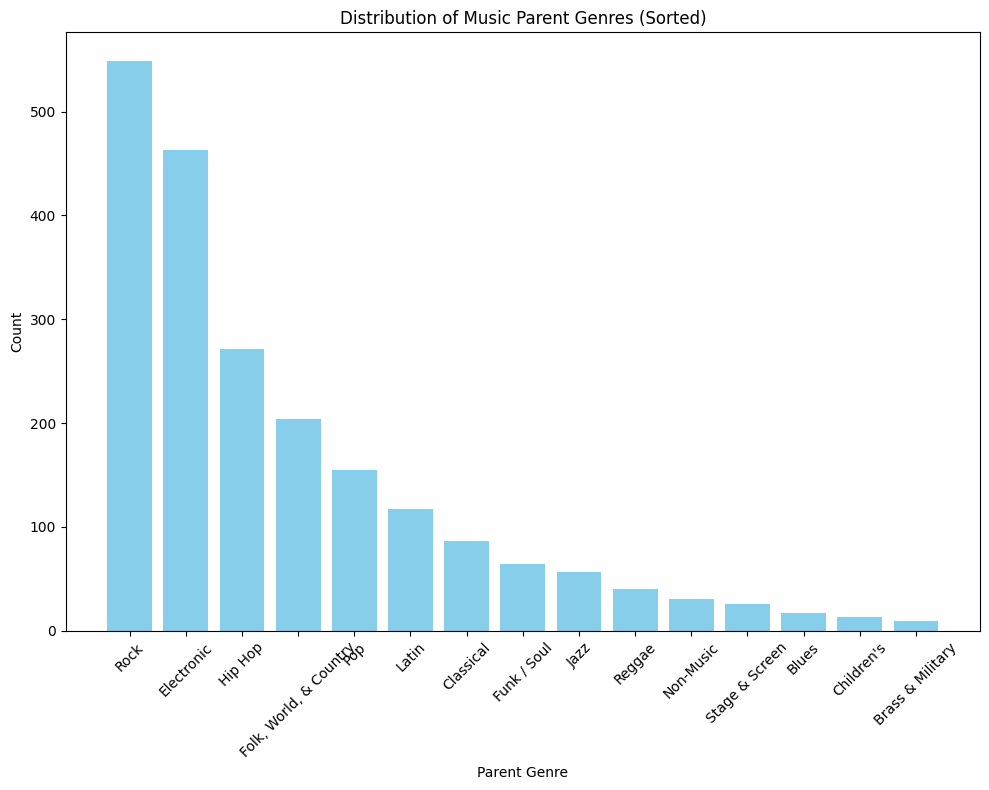

In [73]:
# Load the provided data file
data_path = 'feature/genre_features.pkl'
loaded_genre_features = pd.read_pickle(data_path)

# Initialize a dictionary to hold counts of parent genres
parent_genre_counts = defaultdict(int)

# Iterate through each track's genre activations
for track in loaded_genre_features:
    # Exclude the file_path key for genre processing
    track_genres = {k: v for k, v in track.items() if k != 'file_path'}
    
    # Find the genre with the maximum activation
    max_genre = max(track_genres, key=track_genres.get)
    
    # Extract the parent genre
    parent_genre = max_genre.split('---')[0]
    
    # Increment the count for this parent genre
    parent_genre_counts[parent_genre] += 1

# Convert the parent genre counts to a DataFrame and sort by count in descending order
parent_genre_df = pd.DataFrame(list(parent_genre_counts.items()), columns=['Parent Genre', 'Count'])
sorted_parent_genre_df = parent_genre_df.sort_values('Count', ascending=False)

# Plot the sorted distribution of parent genres
plt.figure(figsize=(10, 8))
plt.bar(sorted_parent_genre_df['Parent Genre'], sorted_parent_genre_df['Count'], color='skyblue')
plt.ylabel('Count')
plt.xlabel('Parent Genre')
plt.title('Distribution of Music Parent Genres (Sorted)')
plt.xticks(rotation=45)  # Rotate the genre names for better readability
plt.tight_layout()
plt.show()

In [81]:
# Save .tsv file for genre counts

# Initialize a new dictionary for  detailed genre counts
detailed_genre_counts = defaultdict(int)

# Iterate through each track's genre activations to only count the genre with the maximum activation
for track in loaded_genre_features:
    # Exclude the file_path key for genre processing
    track_genres = {k: v for k, v in track.items() if k != 'file_path'}
    
    # Find the genre with the maximum activation
    max_genre = max(track_genres, key=track_genres.get)
    
    # Increment the count for this specific genre
    detailed_genre_counts[max_genre] += 1

# Convert the corrected detailed genre counts to a DataFrame
detailed_genre_df = pd.DataFrame(list(detailed_genre_counts.items()), columns=['Genre', 'Count'])

# Add a total row at the end
total_row = pd.DataFrame([{'Genre': 'Total', 'Count': detailed_genre_df['Count'].sum()}])

detailed_genre_df = pd.concat([detailed_genre_df, total_row], ignore_index=True)

# Save the detailed genre counts to a TSV file
tsv_file_path = 'feature/detailed_genre_counts.tsv'
detailed_genre_df.to_csv(tsv_file_path, sep='\t', index=False)

## 2.2 How fast and danceable is the music? Plot tempo and danceability distribution.

In [82]:
data_path = 'feature/extracted_features_without_genre.pkl'
loaded_all_features = pd.read_pickle(data_path)

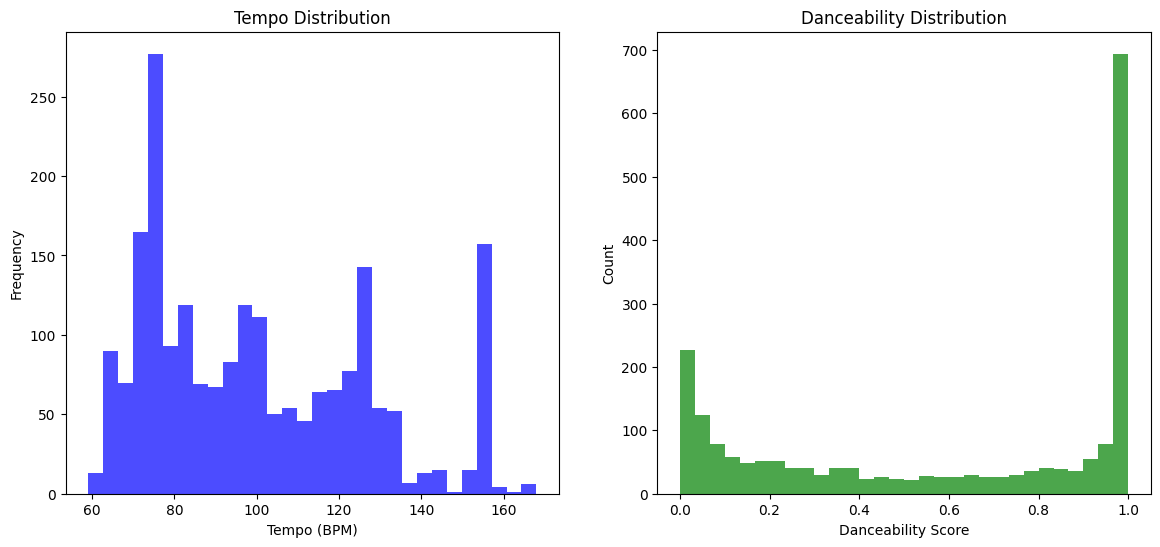

In [89]:
# Extract tempo and danceability values
tempo_values = [track['tempo'] for track in loaded_all_features]
danceability_values = [track['danceability'] for track in loaded_all_features]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot tempo distribution
ax[0].hist(tempo_values, bins=30, color='blue', alpha=0.7)
ax[0].set_title('Tempo Distribution')
ax[0].set_xlabel('Tempo (BPM)')
ax[0].set_ylabel('Frequency')

# Plot danceability distribution
ax[1].hist(danceability_values, bins=30, color='green', alpha=0.7)
ax[1].set_title('Danceability Distribution')
ax[1].set_xlabel('Danceability Score')
ax[1].set_ylabel('Count')

#plt.tight_layout()
plt.show()

## 2.3 Which keys/scales are used in the collection? Plot distribution according to the three profiles we used.

* Temperley Profile Distribution: Reflects the distribution of keys as identified by the Temperley algorithm.
* Krumhansl Profile Distribution: Shows the distribution based on the Krumhansl key finding method.
* EDMA Profile Distribution: Represents the distribution according to the EDMA (Euclidean Distance to Major and minor Averages) method.

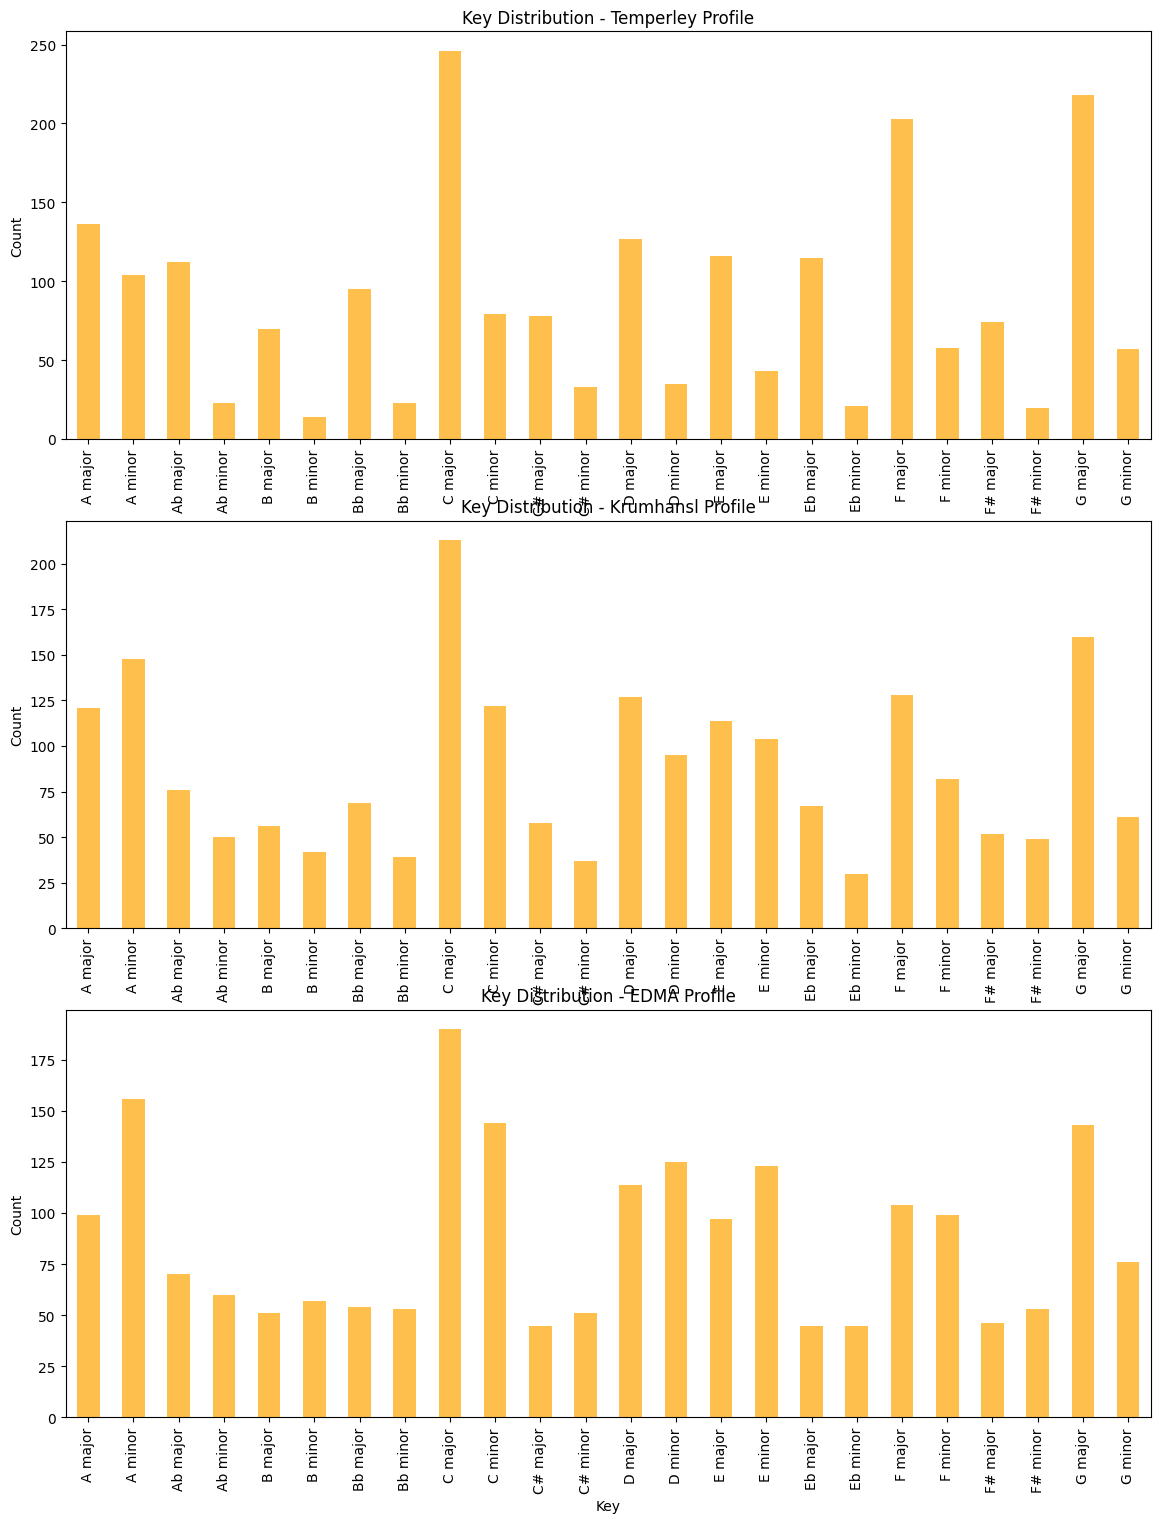

In [91]:
# Extract key and scale information according to the three profiles: Temperley, Krumhansl, and EDMA
key_temperley = [f"{track['key_temperley'][0]} {track['key_temperley'][1]}" for track in loaded_all_features]
key_krumhansl = [f"{track['key_krumhansl'][0]} {track['key_krumhansl'][1]}" for track in loaded_all_features]
key_edma = [f"{track['key_edma'][0]} {track['key_edma'][1]}" for track in loaded_all_features]

# Function to plot the distribution of keys/scales
def plot_key_distribution(keys, title, ax):
    # Count occurrences of each key/scale
    key_counts = pd.Series(keys).value_counts().sort_index()
    # Plot
    key_counts.plot(kind='bar', ax=ax, color='orange', alpha=0.7)
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.set_xlabel('Key')

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

plot_key_distribution(key_temperley, 'Key Distribution - Temperley Profile', axes[0])
plot_key_distribution(key_krumhansl, 'Key Distribution - Krumhansl Profile', axes[1])
plot_key_distribution(key_edma, 'Key Distribution - EDMA Profile', axes[2])

#plt.tight_layout()
plt.show()

## 2.4 What about loudness? Plot integrated loudness LUFS distribution.

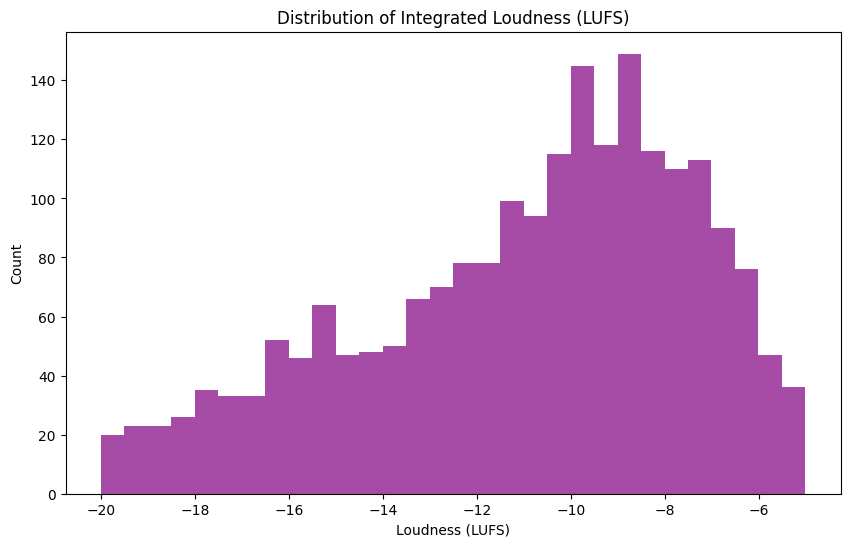

In [92]:
# Extract loudness values
loudness_values = [track['loudness'] for track in loaded_all_features]

# Plotting the distribution of loudness
plt.figure(figsize=(10, 6))
plt.hist(loudness_values, bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Integrated Loudness (LUFS)')
plt.xlabel('Loudness (LUFS)')
plt.ylabel('Count')
plt.show()

## 2.5 How is music represented in terms of arousal/valence emotion space? Plot a 2D distribution.
I've created a more visually appealing plot for the arousal/valence distribution in the emotion space. This plot combines a scatter plot and a density plot (KDE) to highlight both the individual data points and the overall density of points in different areas of the emotion space.

The scatter plot points represent individual tracks, showing their specific arousal and valence values.
The density plot provides a color-coded visualization of the concentration of tracks across the space, with warmer colors indicating higher density (more tracks) and cooler colors indicating lower density.

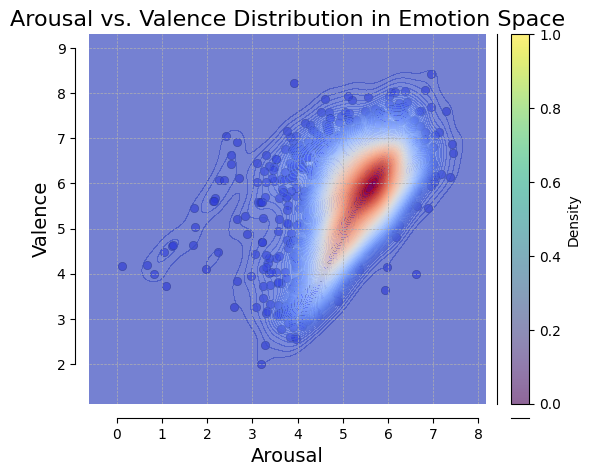

In [94]:
arousal_values = [track['arousal_valance'][0] for track in loaded_all_features]
valence_values = [track['arousal_valance'][1] for track in loaded_all_features]

plt.ylabel('Valence', fontsize=12)
plt.scatter(arousal_values, valence_values, alpha=0.6, color='blue', edgecolor='black', linewidth=0.5)
sns.kdeplot(x=arousal_values, y=valence_values, cmap="coolwarm", fill=True, thresh=0, levels=100, alpha=0.7)
plt.colorbar(label='Density')
plt.title('Arousal vs. Valence Distribution in Emotion Space', fontsize=16)
plt.xlabel('Arousal', fontsize=14)
plt.ylabel('Valence', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(trim=True, offset=10)
plt.show()

## 2.6 How much of the music is vocal vs instrumental? 
The distribution of voice/instrumental values for the music collection has been plotted. This histogram shows how the tracks are spread across the range of voice/instrumental scores, providing insights into the vocal versus instrumental content of the music.

The voice/instrumental score typically ranges from 0 to 1, where:

Values closer to 0 indicate a track is more instrumental.
Values closer to 1 suggest a track is more vocal.

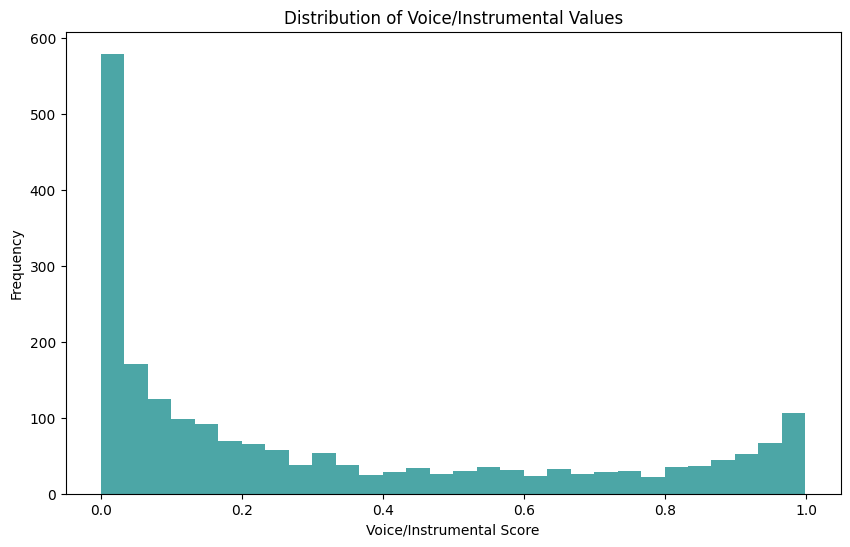

In [95]:
# Extract voice/instrumental values
voice_instrumental_values = [track['voice_instrumental'] for track in loaded_all_features]

# Plotting the distribution of voice/instrumental values
plt.figure(figsize=(10, 6))
plt.hist(voice_instrumental_values, bins=30, color='teal', alpha=0.7)
plt.title('Distribution of Voice/Instrumental Values')
plt.xlabel('Voice/Instrumental Score')
plt.ylabel('Frequency')
plt.show()

# 3. Playlist generation

## 3.1 Playlists based on descriptor queries
streamlit run playlist_descriptor_app.py

## 3.2 Playlists based on track 
streamlit run playlist_descriptor_app.py